In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [3]:
# Make the model - 5 layers with sigmoid activation
nChannels = [3, 6, 12]
filtSize1 = [5,5]
filtSize2 = [4,4]
imChannels = 1 # Gray scale image
X = tf.placeholder(tf.float32, [None, 28, 28, 1])
W1 = tf.Variable(tf.truncated_normal(filtSize1+[imChannels, nChannels[0]], stddev=0.1))
b1 = tf.Variable(tf.ones([nChannels[0]])/10)

W2 = tf.Variable(tf.truncated_normal(filtSize2+nChannels[:2], stddev=0.1))
b2 = tf.Variable(tf.ones([nChannels[1]])/10)

W3 = tf.Variable(tf.truncated_normal(filtSize2+nChannels[1:], stddev=0.1))
b3 = tf.Variable(tf.ones([nChannels[2]])/10)

Nfc= 200
W4 = tf.Variable(tf.truncated_normal([7*7*nChannels[-1], Nfc], stddev=0.1))
b4 = tf.Variable(tf.ones([Nfc])/10)

W5 = tf.Variable(tf.truncated_normal([Nfc, 10], stddev=0.1))
b5 = tf.Variable(tf.ones(10)/10)

In [4]:
init = tf.global_variables_initializer()

In [5]:
# Dropout probability
pKeep = tf.placeholder(tf.float32)

# Model
Y1 = tf.nn.relu( tf.nn.conv2d(X,W1, strides=[1,1,1,1], padding='SAME') + b1)
Y2 = tf.nn.relu( tf.nn.conv2d(Y1,W2, strides=[1,2,2,1], padding='SAME') + b2)
Y3 = tf.nn.relu( tf.nn.conv2d(Y2, W3, strides=[1,2,2,1], padding='SAME') + b3)

# Flatten output of convolutional layers
YY = tf.reshape( Y3, shape=[-1, 7*7*nChannels[-1]])
# Connect convolutional layer to FC layer
Y4 = tf.nn.relu( tf.matmul(YY, W4) + b4) 
Y4d= tf.nn.dropout( Y4, pKeep )
Y5 = tf.nn.softmax( tf.matmul(Y4d, W5) + b5) * (1-1e-8) + 1e-8

# Prepare teacher vector
Y_ = tf.placeholder(tf.float32, [None, 10])

In [6]:
# Loss
cost = -tf.reduce_sum(Y_ * tf.log(Y5))

In [7]:
# Nb of correct answers in batch
is_correct = tf.equal( tf.argmax(Y_, 1), tf.argmax(Y5, 1) )
accuracy = tf.reduce_mean( tf.cast(is_correct, tf.float32))

In [8]:
dec = 0.003 / np.exp( np.array(range(10000))/3000 )
dec[0]

0.0030000000000000001

In [9]:
# Training - set training method
decay = tf.placeholder(tf.float32)
optimizer = tf.train.GradientDescentOptimizer( decay )
# Training - make a step
train_step = optimizer.minimize(cost)

In [10]:
# Load data
import utils.RBrown_input_data as rbm
dt_path = '/Users/younes_zerouali/Documents/Stradigi/Databases/MNIST' 
mnist = rbm.read_data_sets(dt_path, one_hot=True)

Extracting /Users/younes_zerouali/Documents/Stradigi/Databases/MNIST/train-images-idx3-ubyte.gz
Extracting /Users/younes_zerouali/Documents/Stradigi/Databases/MNIST/train-labels-idx1-ubyte.gz
Extracting /Users/younes_zerouali/Documents/Stradigi/Databases/MNIST/t10k-images-idx3-ubyte.gz
Extracting /Users/younes_zerouali/Documents/Stradigi/Databases/MNIST/t10k-labels-idx1-ubyte.gz


In [11]:
sess = tf.Session()
sess.run(init)

In [12]:
# Loop and train/test
ACCtr = []
LOStr = []
ACCts = []
LOSts = []
dec = 0.003 / np.exp( np.array(range(10000))/3000 )
for i,d in zip(range(10000), dec):
    # Get a batch
    batchX, batchY = mnist.train.next_batch(100)
    batchX = np.array( [np.reshape(batchX[x,:], [28,28,1]) for x in range(100)] )
    # TRAIN: make training dictionary
    trdict = {X:batchX, Y_:batchY, decay:d, pKeep:0.75}
    # TRAIN: update weigths
    sess.run(train_step, feed_dict=trdict)
    # TRAIN: accuracy
    a,c = sess.run([accuracy, cost], feed_dict=trdict)
    ACCtr.append(a)    
    LOStr.append(c)
    # Log weights
    Ww5 = sess.run(W5)
    # TEST
    testX, testY = mnist.test.next_batch(100)
    testX = np.array( [np.reshape(testX[x,:], [28,28,1]) for x in range(100)] )
    tsdict = {X:testX, Y_:testY, pKeep:1}
    a,c = sess.run([accuracy, cost], feed_dict=tsdict)
    ACCts.append(a)    
    LOSts.append(c)
    if i%99==0: print('Accuracy at iteration %i: %f' %(i, a)) 

Accuracy at iteration 0: 0.100000
Accuracy at iteration 99: 0.860000
Accuracy at iteration 198: 0.960000
Accuracy at iteration 297: 0.960000
Accuracy at iteration 396: 0.990000
Accuracy at iteration 495: 0.970000
Accuracy at iteration 594: 0.970000
Accuracy at iteration 693: 0.990000
Accuracy at iteration 792: 0.970000
Accuracy at iteration 891: 0.970000
Accuracy at iteration 990: 0.990000
Accuracy at iteration 1089: 1.000000
Accuracy at iteration 1188: 0.980000
Accuracy at iteration 1287: 0.980000
Accuracy at iteration 1386: 0.980000
Accuracy at iteration 1485: 0.990000
Accuracy at iteration 1584: 0.990000
Accuracy at iteration 1683: 0.990000
Accuracy at iteration 1782: 0.980000
Accuracy at iteration 1881: 1.000000
Accuracy at iteration 1980: 0.980000
Accuracy at iteration 2079: 0.990000
Accuracy at iteration 2178: 0.970000
Accuracy at iteration 2277: 1.000000
Accuracy at iteration 2376: 1.000000
Accuracy at iteration 2475: 0.980000
Accuracy at iteration 2574: 1.000000
Accuracy at ite

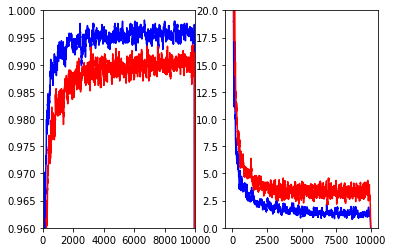

In [13]:
FIG = plt.figure()
N_run = 50

# Plot accuracy
Ax1 = FIG.add_subplot(121)
Ax1.plot( range(10000), np.convolve( np.concatenate( (ACCtr, np.zeros(N_run-1,)) ), np.ones((N_run,))/N_run, mode='valid'), 'b', label='training accuracy')
Ax1.plot( range(10000), np.convolve( np.concatenate( (ACCts, np.zeros(N_run-1,)) ), np.ones((N_run,))/N_run, mode='valid'), 'r', label='test accuracy')
Ax1.set_ylim([0.96, 1])
Ax1.set_xlim([0, 10000-10])
Ax1.x_label = 'Iteration number'

# Plot loss
Ax2 = FIG.add_subplot(122)
Ax2.plot( range(10000), np.convolve( np.concatenate( (LOStr, np.zeros(N_run-1,)) ), np.ones((N_run,))/N_run, mode='valid'), 'b', label='training loss')
Ax2.plot( range(10000), np.convolve( np.concatenate( (LOSts, np.zeros(N_run-1,)) ), np.ones((N_run,))/N_run, mode='valid'), 'r', label='test loss')
Ax2.set_ylim([0, 20])
Ax2.x_label = 'Iteration number'

In [17]:
np.mean(ACC)

1.0

In [18]:
ACC

[1.0]